In [54]:
import os
import shutil
import random

In [55]:
import cv2
import numpy as np


In [56]:
import matplotlib.pyplot as plt

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights, mobilenet_v2, MobileNet_V2_Weights, vgg16, VGG16_Weights, vgg19, VGG19_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
print("CUDA Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA Available: True
Device Count: 1
Current Device: 0
Device Name: NVIDIA GeForce GTX 1650


In [59]:
train_dir = "data/Training"
validation_dir = "data/validation"

In [60]:
image = cv2.imread("data\Training\glioma_tumor\gg (2).jpg", cv2.IMREAD_GRAYSCALE)
print()

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\telat\AppData\Local\Temp\ipykernel_20876\3243487661.py:1: SyntaxWarning: invalid escape sequence '\T'
  image = cv2.imread("data\Training\glioma_tumor\gg (2).jpg", cv2.IMREAD_GRAYSCALE)


In [61]:
lowest = np.inf
highest = -np.inf

img_vector = np.array(image).flatten()

for i in img_vector:
    if lowest > i:
        lowest = i
    if highest < i:
        highest = i

print(lowest)
print(highest)

0
255


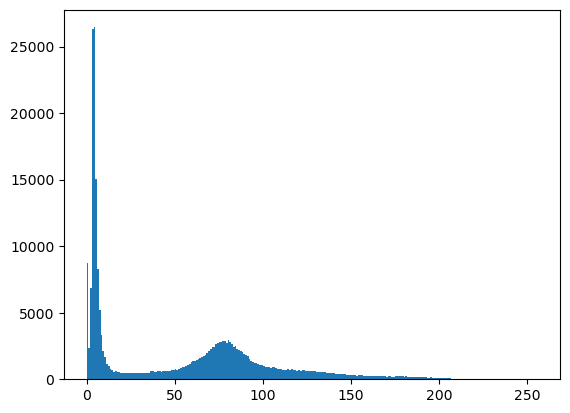

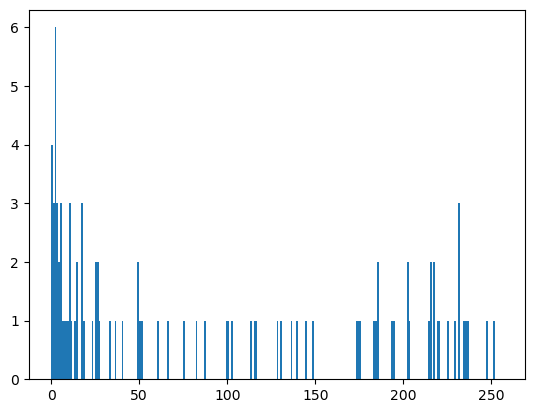

In [62]:
hist = cv2.calcHist([image],[0],None,[256],[0,256])
plt.hist(image.ravel(),256,[0,256])
plt.show()

equ = cv2.equalizeHist(image)

hist = cv2.calcHist([image],[0],None,[256],[0,256])
plt.hist(hist.ravel(),256,[0,256])
plt.show()

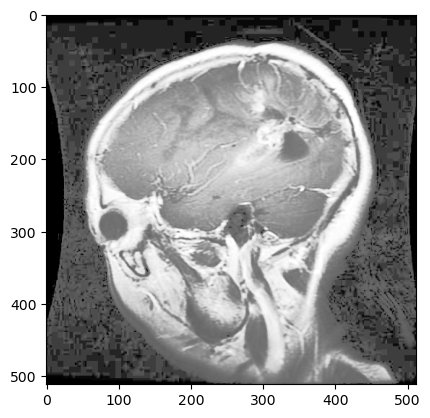

In [63]:
plt.imshow(equ, cmap="gray")
plt.show()

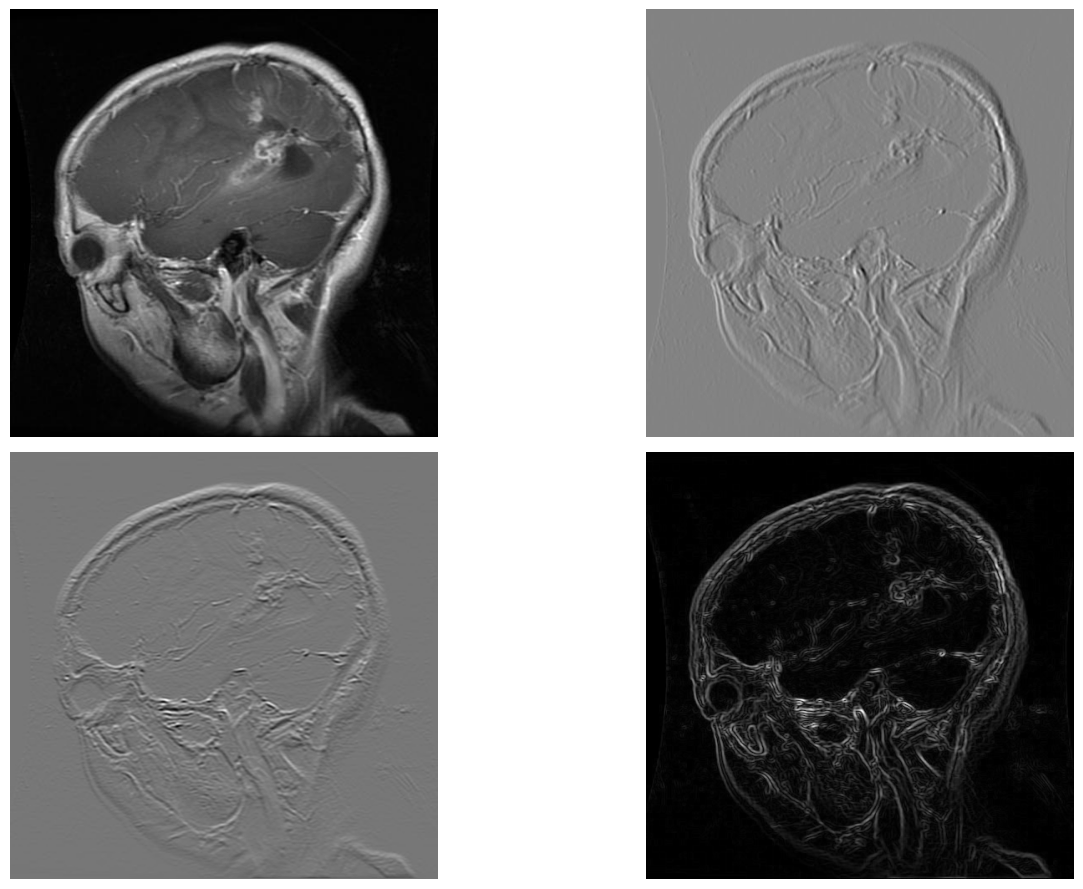

In [64]:
sobel_x = np.array([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -1, -1],
                    [0,  0,  0],
                    [1,  1,  1]])


gradient_x = cv2.filter2D(image, cv2.CV_64F, sobel_x)
gradient_y = cv2.filter2D(image, cv2.CV_64F, sobel_y)
gradient_xy = cv2.magnitude(gradient_x, gradient_y)

images = [image, gradient_x, gradient_y, gradient_xy]

fig, axes = plt.subplots(2, 2, figsize=(15,9))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()

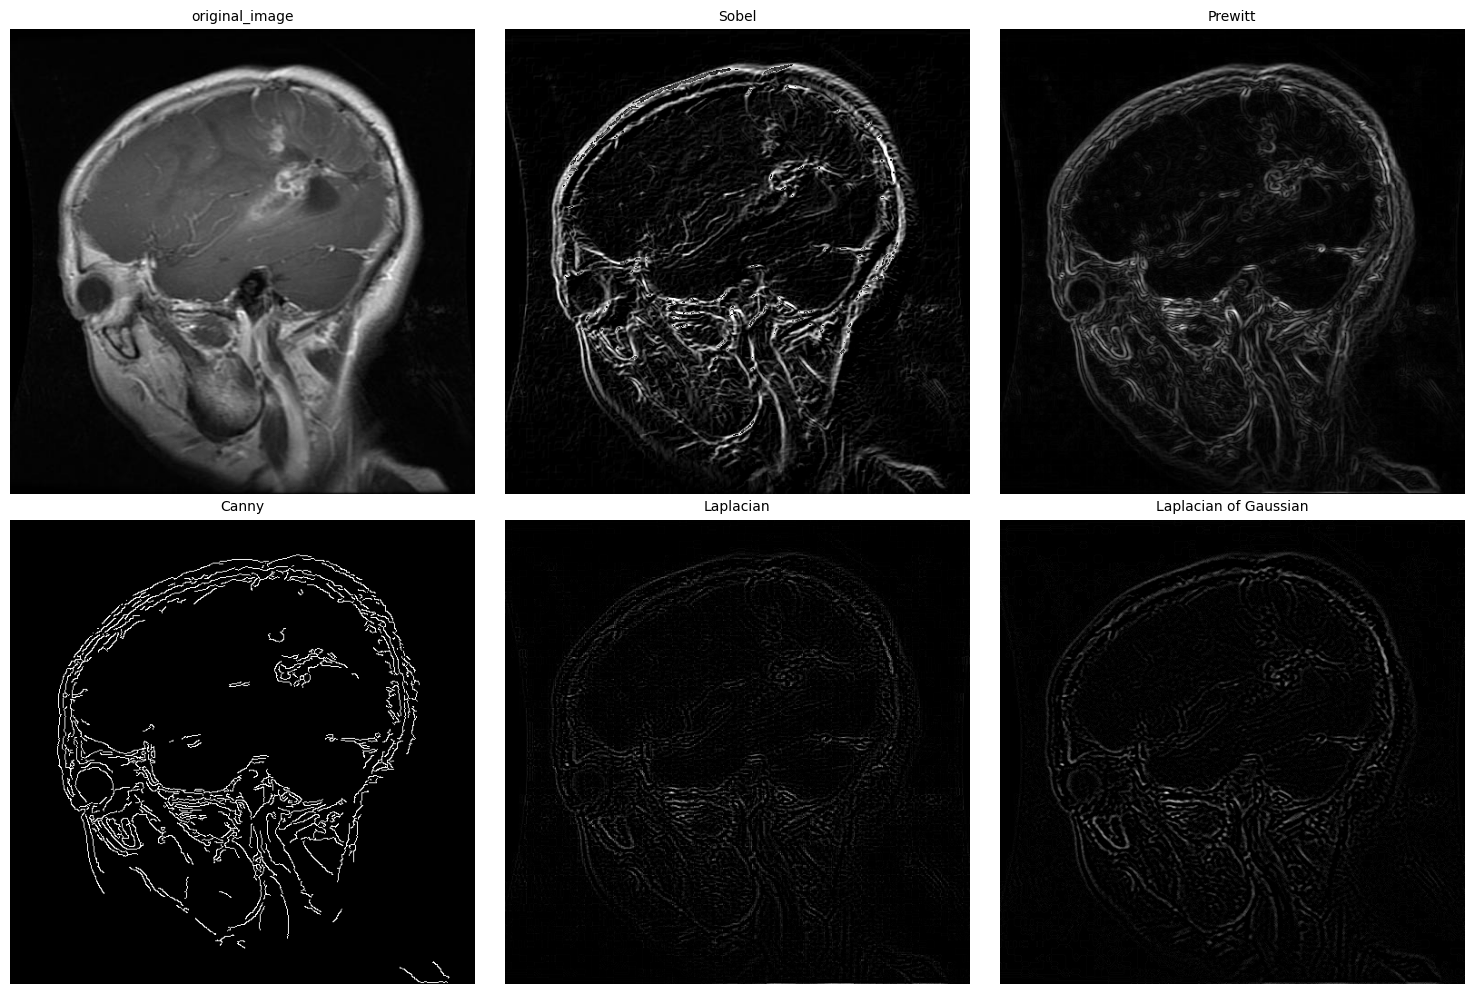

In [65]:

def prewitt_edge_detection(image):

    kernel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    kernel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    grad_x = cv2.filter2D(image, cv2.CV_64F, kernel_x)
    grad_y = cv2.filter2D(image, cv2.CV_64F, kernel_y)
    grad = cv2.magnitude(grad_x, grad_y)
    return grad

sobel_edges = cv2.Sobel(image, -1, 1, 0, ksize=3) + cv2.Sobel(image, -1, 0, 1, ksize=3)
prewitt_edges = prewitt_edge_detection(image)
canny_edges = cv2.Canny(image, 100, 200)
laplacian_edges = cv2.Laplacian(image, -1)
log_edges = cv2.GaussianBlur(image, (5, 5), 0)
log_edges = cv2.Laplacian(log_edges, -1)

images = [image, sobel_edges, prewitt_edges, canny_edges, laplacian_edges, log_edges]
descriptions = ["original_image", "Sobel", "Prewitt", "Canny", "Laplacian", "Laplacian of Gaussian"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(descriptions[i], fontsize=10)
    ax.axis('off') 

plt.tight_layout()
plt.show()

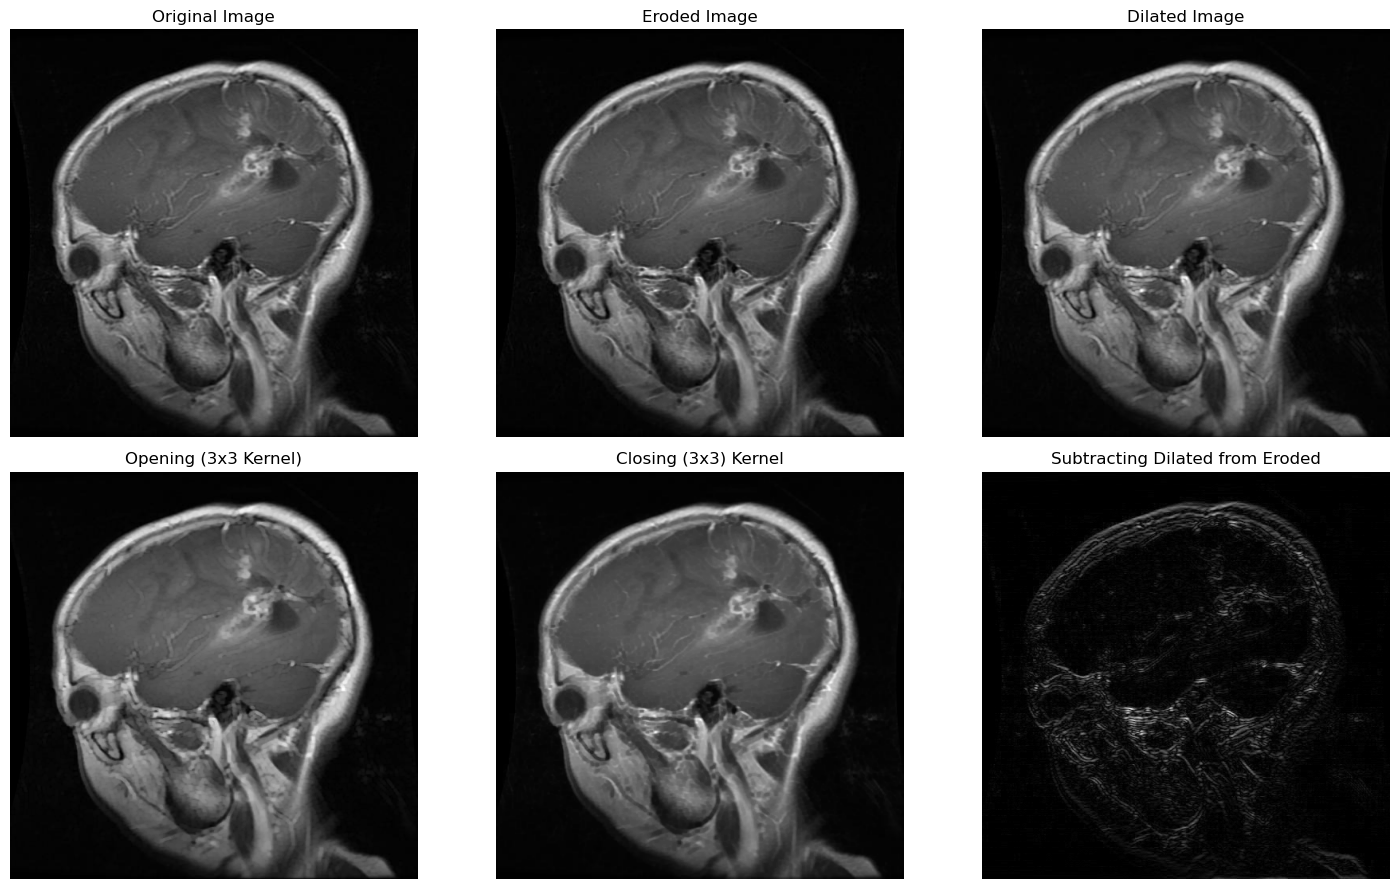

In [66]:
# Erosion demonstration (fixed single erosion example)
eroded = cv2.erode(image.copy(), (5,5), iterations=1)

# Dilation demonstration (fixed single dilation example)
dilated = cv2.dilate(image.copy(), (5,5), iterations=1)

# Morphological opening with a kernel size of (3, 3)
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel_open)

# Morphological closing with a kernel size of (3, 3)
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_open)

# Subtracting Dilated from Eroded
subtraction_result = cv2.subtract(dilated, eroded)

# Display images using matplotlib
images = [image, eroded, dilated, opening, closing, subtraction_result]
titles = ['Original Image', 'Eroded Image', 'Dilated Image', 'Opening (3x3 Kernel)', 'Closing (3x3) Kernel', 'Subtracting Dilated from Eroded']

fig, axes = plt.subplots(2, 3, figsize=(15, 9))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')  
    ax.set_title(titles[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

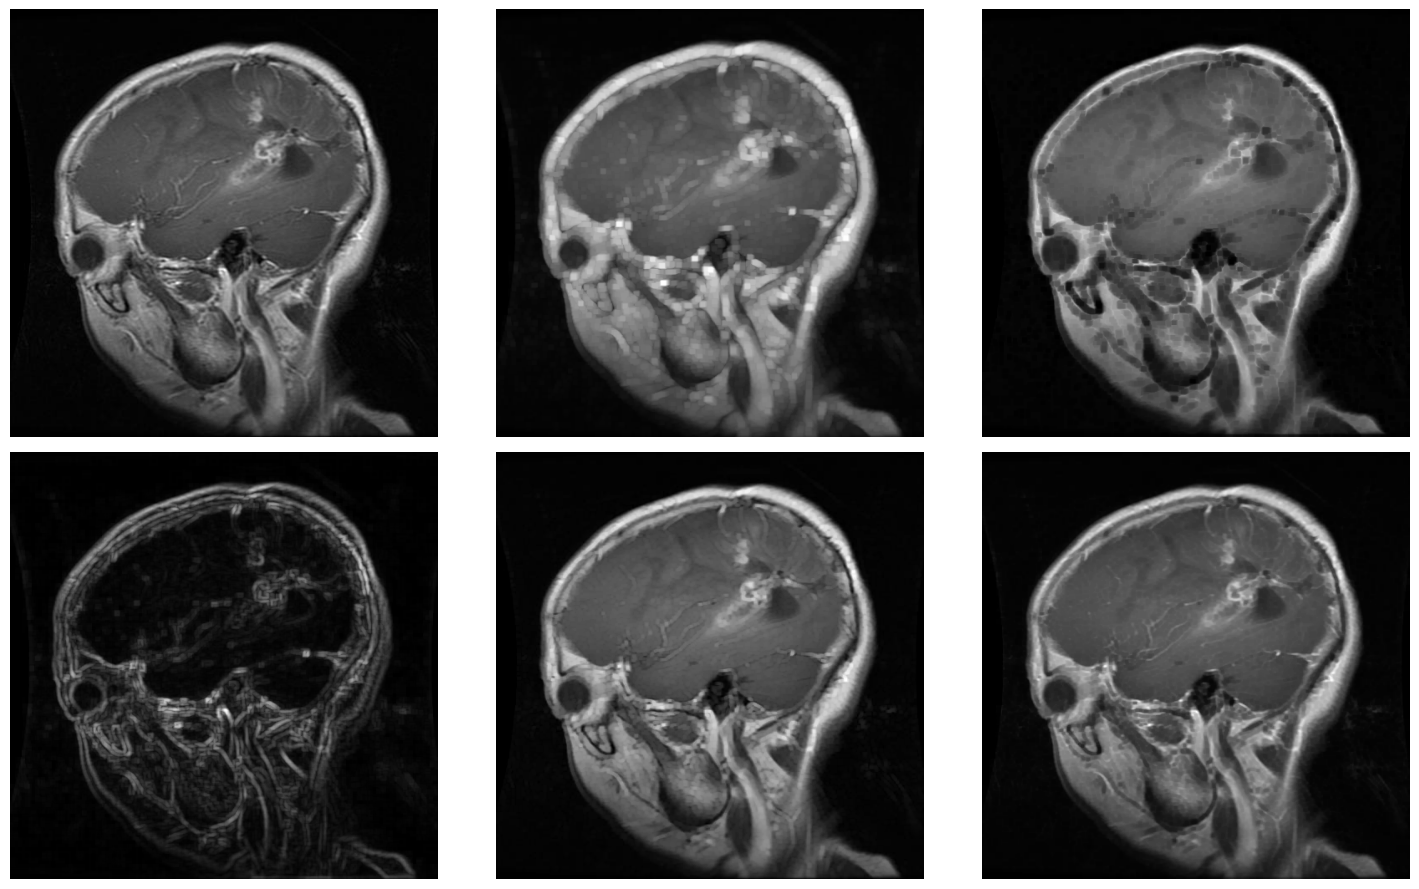

In [67]:
kernel_size = 5
kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)

dilated_image_cv2 = cv2.dilate(image, kernel, iterations=1)
eroded_image_cv2 = cv2.erode(image, kernel, iterations=1)

# Define a structuring element (e.g., a 3x3 square)
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# Calculate the Morphological Gradient (Dilation - Erosion)
morphological_gradient = cv2.subtract(dilated_image_cv2, eroded_image_cv2)

opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, structuring_element)
closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, structuring_element)


images = [image, dilated_image_cv2, eroded_image_cv2, morphological_gradient, opened_image, closed_image]


fig, axes = plt.subplots(2, 3, figsize=(15, 9))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')  
    ax.axis("off")

plt.tight_layout()
plt.show()

In [68]:
"""
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

for category in categories:
    os.makedirs(os.path.join(validation_dir, category), exist_ok=True)

for category in categories:
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    num_validation = int(0.2 * len(images))

    validation_images = random.sample(images, num_validation)
    for image in validation_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(validation_dir, category, image)
        shutil.move(src, dst)

print(f"20% of training data moved to validation set.")
"""

'\ncategories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]\n\nfor category in categories:\n    os.makedirs(os.path.join(validation_dir, category), exist_ok=True)\n\nfor category in categories:\n    category_path = os.path.join(train_dir, category)\n    images = os.listdir(category_path)\n    num_validation = int(0.2 * len(images))\n\n    validation_images = random.sample(images, num_validation)\n    for image in validation_images:\n        src = os.path.join(category_path, image)\n        dst = os.path.join(validation_dir, category, image)\n        shutil.move(src, dst)\n\nprint(f"20% of training data moved to validation set.")\n'

In [69]:
print(f"glioma_tumor train: {len(os.listdir("data/Training/glioma_tumor"))}")
print(f"meningioma_tumor train: {len(os.listdir("data/Training/meningioma_tumor"))}")
print(f"no_tumor train: {len(os.listdir("data/Training/no_tumor"))}")
print(f"pituitary_tumor train: {len(os.listdir("data/Training/pituitary_tumor"))}")
print()
print(f"glioma_tumor validation: {len(os.listdir("data/validation/glioma_tumor"))}")
print(f"meningioma_tumor validation: {len(os.listdir("data/validation/meningioma_tumor"))}")
print(f"no_tumor validation: {len(os.listdir("data/validation/no_tumor"))}")
print(f"pituitary_tumor validation: {len(os.listdir("data/validation/pituitary_tumor"))}")
print()
print(f"glioma_tumor test: {len(os.listdir("data/Testing/glioma_tumor"))}")
print(f"meningioma_tumor test: {len(os.listdir("data/Testing/meningioma_tumor"))}")
print(f"no_tumor test: {len(os.listdir("data/Testing/no_tumor"))}")
print(f"pituitary_tumor test: {len(os.listdir("data/Testing/pituitary_tumor"))}")


glioma_tumor train: 661
meningioma_tumor train: 658
no_tumor train: 316
pituitary_tumor train: 662

glioma_tumor validation: 165
meningioma_tumor validation: 164
no_tumor validation: 79
pituitary_tumor validation: 165

glioma_tumor test: 100
meningioma_tumor test: 115
no_tumor test: 105
pituitary_tumor test: 74


In [70]:
class MorphologicalGradient:

    def __init__(self, kernel_size = 3):
        self.kernel_size = kernel_size


    def __call__(self, image):

        kernel = np.ones((self.kernel_size, self.kernel_size), dtype=np.uint8)
        
        dilated_image_cv2 = cv2.dilate(image, kernel, iterations=1)
        eroded_image_cv2 = cv2.erode(image, kernel, iterations=1)

        # Calculate the Morphological Gradient (Dilation - Erosion)
        morphological_gradient = cv2.subtract(dilated_image_cv2, eroded_image_cv2)

        return morphological_gradient


In [71]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [72]:
train_data = datasets.ImageFolder(root="data/Training", transform=transform)
validation_data = datasets.ImageFolder(root="data/validation", transform=transform)
test_data = datasets.ImageFolder(root="data/Testing", transform=transform)

In [73]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=2)

In [74]:
class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

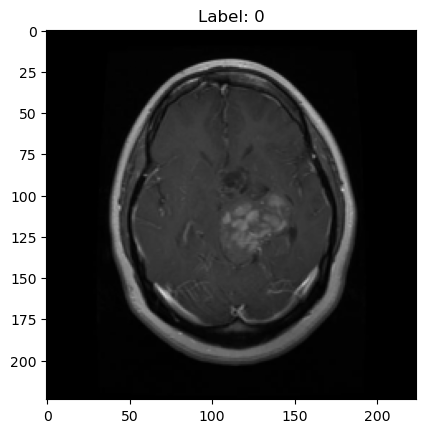

In [75]:
image, label = train_data[0]

if hasattr(image, 'numpy'):
    image = image.numpy().transpose((1, 2, 0))  # Adjust dimensions if needed (e.g., channels-first to channels-last)

plt.imshow(image)
plt.title(f'Label: {label}')
plt.show()

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, num_classes=4):
        super(NeuralNet, self).__init__()

        # Load pretrained MobileNetV2 model
        base_model = models.mobilenet_v2(pretrained=True)  # PyTorch equivalent of MobileNet
        self.base_model = nn.Sequential(*list(base_model.features.children()))  # Extract feature layers
        
        # Freeze the base model layers
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Add new layers on top of the base model
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.fc1 = nn.Linear(1280, 128)  # 1280 is the output channel size of MobileNetV2
        self.dropout = nn.Dropout(0.2)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.base_model(x)  # Pass through base MobileNet layers
        x = self.global_avg_pool(x)  # Global average pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        x = torch.softmax(x, dim=1)
        return x

In [80]:
net = NeuralNet().to(device)
loss_function = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)
# l2 regularization
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay=0.01, momentum=0.9)

C:\Users\telat\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
epochs = 100
min_valid_loss = np.inf
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

for epoch in range(epochs):
    print(f"Training epoch {epoch+1}...")

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    net.train()  # Ensure the model is in training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    net.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Disable gradient calculations for validation
        for data, labels in validation_loader:
            data = data.to(device)
            labels = labels.to(device)
            target = net(data)
            loss = loss_function(target, labels)
            valid_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(target, 1)
            correct_valid += (predicted == labels).sum().item()
            total_valid += labels.size(0)

            # Save the best model based on validation loss
            if min_valid_loss > valid_loss:
                print(f'Validation Loss Decreased({min_valid_loss:.4f}--->{valid_loss:.4f}) \t Saving The Model')
                min_valid_loss = valid_loss
                torch.save(net.state_dict(), 'trained_net_full.pth')

    validation_losses.append(valid_loss / len(validation_loader))
    validation_accuracy = 100 * correct_valid / total_valid
    validation_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1} \t Training Loss: {running_loss / len(train_loader):.4f} \t Validation Loss: {valid_loss / len(validation_loader):.4f}')
    print(f'Training Accuracy: {train_accuracy:.2f}% \t Validation Accuracy: {validation_accuracy:.2f}%')

Training epoch 1...
Validation Loss Decreased(inf--->1.2225) 	 Saving The Model
Epoch 1 	 Training Loss: 1.3178 	 Validation Loss: 1.2009
Training Accuracy: 48.41% 	 Validation Accuracy: 66.49%
Training epoch 2...
Validation Loss Decreased(1.2225--->0.9626) 	 Saving The Model
Epoch 2 	 Training Loss: 1.1556 	 Validation Loss: 1.0888
Training Accuracy: 67.57% 	 Validation Accuracy: 71.90%
Training epoch 3...
Validation Loss Decreased(0.9626--->0.9394) 	 Saving The Model
Epoch 3 	 Training Loss: 1.0794 	 Validation Loss: 1.0336
Training Accuracy: 71.48% 	 Validation Accuracy: 75.92%
Training epoch 4...
Epoch 4 	 Training Loss: 1.0350 	 Validation Loss: 1.0077
Training Accuracy: 75.36% 	 Validation Accuracy: 76.27%
Training epoch 5...
Validation Loss Decreased(0.9394--->0.8951) 	 Saving The Model
Epoch 5 	 Training Loss: 1.0146 	 Validation Loss: 0.9839
Training Accuracy: 76.06% 	 Validation Accuracy: 78.53%
Training epoch 6...
Epoch 6 	 Training Loss: 0.9948 	 Validation Loss: 0.9696
Tra

KeyboardInterrupt: 

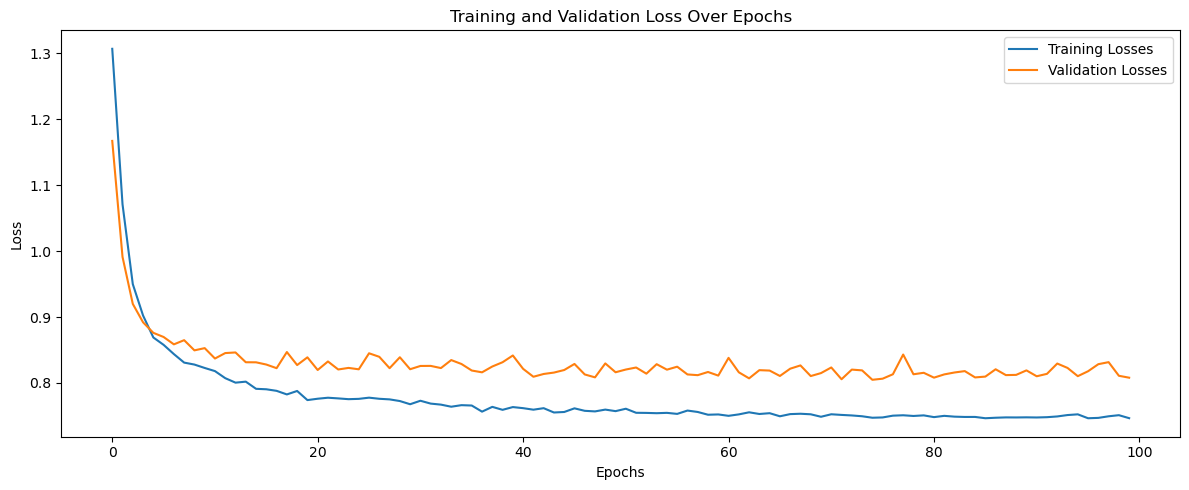

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(range(0, 100), train_losses, label="Training Losses")
plt.plot(range(0, 100), validation_losses, label="Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss Over Epochs')
plt.legend()


plt.tight_layout()
plt.show()


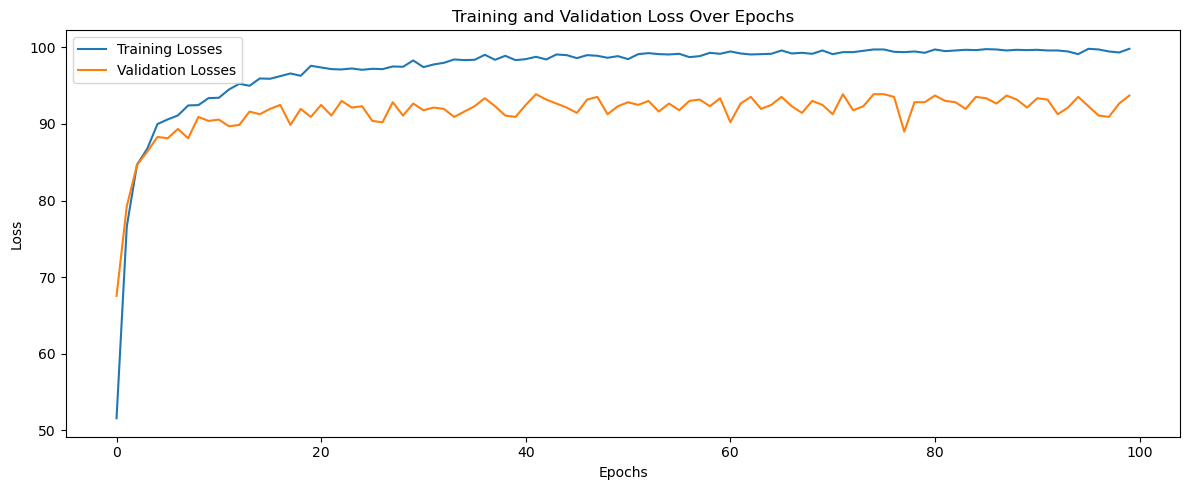

In [36]:
plt.figure(figsize=(12, 5))

plt.plot(range(0, 100), train_accuracies, label="Training Losses")
plt.plot(range(0, 100), validation_accuracies, label="Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss Over Epochs')
plt.legend()


plt.tight_layout()
plt.show()

In [37]:

net = NeuralNet().to(device)

net.load_state_dict(torch.load("trained_net_full.pth"))

C:\Users\telat\AppData\Local\Temp\ipykernel_20876\880310379.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("trained_net_full.pth"))


<All keys matched successfully>

In [38]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predict = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()


accuracy = 100 * correct / total 

print(f"Accuracy: {accuracy}%")

Accuracy: 73.85786802030456%
